In [47]:
# from: https://github.com/gregornickel/pcp
import csv
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from copy import deepcopy


def load_csv(filename):
    with open(filename, "r") as f:
        reader = csv.reader(f)
        data_list = list(reader)

    results = []
    for i in range(1, len(data_list)):
        result = []
        for j in data_list[i]:
            if "." in j or "e" in j:
                try:
                    result.append(float(j))
                except ValueError:
                    result.append(j)
            else:
                try:
                    result.append(int(j))
                except ValueError:
                    result.append(j)

        results.append(result)

    return results, data_list[0]


def check_data(data, labels):
    for i in range(len(data)):
        assert len(data[i]) is len(labels), "data dimension (%d) does not " \
            "match with labels (%d)" % (len(data[i]), len(labels))


def check_formatting(yattribute, labels):
    if yattribute:
        assert len(yattribute) is len(labels), "dimension (%d) does not " \
            "match with labels (%d)" % (len(yattribute), len(labels))
    else:
        yattribute = [[]] * len(labels)
    return yattribute


def set_ytype(ytype, data, colorbar):
    for i in range(len(ytype)):
        if not ytype[i]:
            if type(data[0][i]) is str:
                ytype[i] = "categorial"
            else:
                ytype[i] = "linear"
    if colorbar: 
        assert ytype[len(ytype) - 1] == "linear", "colorbar axis needs to " \
            "be linear"
    return ytype


def set_ylabels(ylabels, data, ytype):
    for i in range(len(ylabels)): 
        # Generate ylabels for string values
        if not ylabels[i] and ytype[i] == "categorial":
            ylabel = []
            for j in range(len(data)):
                if data[j][i] not in ylabel:
                    ylabel.append(data[j][i])
            ylabel.sort()
            if len(ylabel) == 1:
                ylabel.append("")
            ylabels[i] = ylabel
    return ylabels


def replace_str_values(data, ytype, ylabels):
    for i in range(len(ytype)):
        if ytype[i] == "categorial":
            for j in range(len(data)):
                data[j][i] = ylabels[i].index(data[j][i])
    return np.array(data).transpose()


def set_ylim(ylim, data):
    for i in range(len(ylim)):
        if not ylim[i]:
            ylim[i] = [np.min(data[i, :]), np.max(data[i, :])]
            if ylim[i][0] == ylim[i][1]:
                ylim[i] = [ylim[i][0] * 0.95, ylim[i][1] * 1.05]
            if ylim[i] == [0.0, 0.0]:
                ylim[i] = [0.0, 1.0]
    return ylim


def get_score(data, ylim):
    ymin = ylim[len(ylim) - 1][0]
    ymax = ylim[len(ylim) - 1][1]
    score = (np.copy(data[len(ylim) - 1, :]) - ymin) / (ymax - ymin)
    return score


# Rescale data of secondary y-axes to scale of first y-axis
def rescale_data(data, ytype, ylim):
    min0 = ylim[0][0]
    max0 = ylim[0][1]
    scale = max0 - min0
    for i in range(1, len(ylim)):
        mini = ylim[i][0]
        maxi = ylim[i][1]
        if ytype[i] == "log":
            logmin = np.log10(mini)
            logmax = np.log10(maxi)
            span = logmax - logmin
            data[i, :] = ((np.log10(data[i, :]) - logmin) / span) * scale + min0
        else:
            data[i, :] = ((data[i, :] - mini) / (maxi - mini)) * scale + min0
    return data


def get_path(data, i):
    n = data.shape[0] # number of y-axes
    verts = list(zip([x for x in np.linspace(0, n - 1, n * 3 - 2)], 
        np.repeat(data[:, i], 3)[1:-1]))
    codes = [Path.MOVETO] + [Path.CURVE4 for _ in range(len(verts) - 1)]
    path = Path(verts, codes)
    return path


def pcp(data, 
        labels, 
        ytype=None, 
        ylim=None, 
        ylabels=None, 
        figsize=(10, 5), 
        dpi=300,
        rect=[0.125, 0.1, 0.75, 0.8], 
        curves=True,
        alpha=1.0,
        colorbar=True, 
        colorbar_width=0.02,
        cmap=plt.get_cmap("inferno")
        ):
    """
    Parallel Coordinates Plot 

    Parameters
    ----------
    data: nested array
        Inner arrays containing data for each curve.
    labels: list
        Labels for y-axes.
    ytype: list, optional
        Default "None" allows linear axes for numerical values and categorial 
        axes for data of type string. If ytype is passed, logarithmic axes are 
        also possible, e.g.  ["categorial", "linear", "log", [], ...]. Vacant 
        fields must be filled with an empty list []. 
    ylim: list, optional
        Custom min and max values for y-axes, e.g. [[0, 1], [], ...].
    ylabels: list, optional (not recommended)
        Only use this option if you want to print more categories than you have
        in your dataset for categorial axes. You also have to set the right 
        ylim for this option to work correct.
    figsize: (float, float), optional
        Width, height in inches.
    rect: array, optional
        [left, bottom, width, height], defines the position of the figure on
        the canvas. 
    curves: bool, optional
        If True, B-spline curve is drawn.
    alpha: float, optional
        Alpha value for blending the curves.
    colorbar: bool, optional
        If True, colorbar is drawn.
    colorbar_width: float, optional
        Defines the width of the colorbar.
    cmap: matplotlib.colors.Colormap, optional
        Specify colors for colorbar.
    
    Returns
    -------
    `~matplotlib.figure.Figure`
    """
    
    [left, bottom, width, height] = rect
    data = deepcopy(data)
    
    # Check data
    check_data(data, labels)
    ytype = check_formatting(ytype, labels)
    ylim = check_formatting(ylim, labels)
    ylabels = check_formatting(ylabels, labels)

    # Setup data
    ytype = set_ytype(ytype, data, colorbar) 
    ylabels = set_ylabels(ylabels, data, ytype)
    data = replace_str_values(data, ytype, ylabels)
    ylim = set_ylim(ylim, data)
    score = get_score(data, ylim)
    data = rescale_data(data, ytype, ylim)

    # Create figure
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax0 = fig.add_axes([left, bottom, width, height])
    axes = [ax0] + [ax0.twinx() for i in range(data.shape[0] - 1)]

    # Plot curves
    for i in range(data.shape[1]):
        if colorbar:
            color = cmap(score[i])
        else:
            color = "blue"

        if curves:
            path = get_path(data, i)
            patch = PathPatch(path, facecolor="None", lw=1.5, alpha=alpha, 
                    edgecolor=color, clip_on=False)
            ax0.add_patch(patch)
        else:
            ax0.plot(data[:, i], color=color, alpha=alpha, clip_on=False)

    # Format x-axis
    ax0.xaxis.tick_top()
    ax0.xaxis.set_ticks_position("none")
    ax0.set_xlim([0, data.shape[0] - 1])
    ax0.set_xticks(range(data.shape[0]))
    ax0.set_xticklabels(labels)

    # Format y-axis
    for i, ax in enumerate(axes):
        ax.spines["left"].set_position(("axes", 1 / (len(labels) - 1) * i))
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        
        ax.yaxis.set_ticks_position("left")
        ax.set_ylim(ylim[i])
        if ytype[i] == "log":
            ax.set_yscale("log")
        if ytype[i] == "categorial":
            ax.set_yticks(range(len(ylabels[i])))
        if ylabels[i]:
            ax.set_yticklabels(ylabels[i])
        
    if colorbar:
        bar = fig.add_axes([left + width, bottom, colorbar_width, height])
        norm = mpl.colors.Normalize(vmin=ylim[i][0], vmax=ylim[i][1])
        mpl.colorbar.ColorbarBase(bar, cmap=cmap, norm=norm, 
            orientation="vertical")
        bar.tick_params(size=0)
        bar.set_yticklabels([])

    return fig

In [2]:
import pandas as pd 
import wandb
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("rug-minds/parse-ego4d")

params_per_model = {
    "avsolatorio/GIST-small-Embedding-v0": 33.36e6,
    "Alibaba-NLP/gte-base-en-v1.5": 136.776192e6,
    "Alibaba-NLP/gte-large-en-v1.5": 434.139136e6,
    "google/mobilebert-uncased": 24.581888e6,
    "google/gemma-2b-it": -1,
}
embedding_sizes = {
    "avsolatorio/GIST-small-Embedding-v0": 384,
    "Alibaba-NLP/gte-base-en-v1.5": 768,
    "Alibaba-NLP/gte-large-en-v1.5": 1024,
    "google/mobilebert-uncased": 512,
}
N_CLASSES = 6

rows = []
for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    row = {
        "name": run.name,
        'state': run.state,
        'model_name': run.config.get('model_name', None),
        'layer_sizes': run.config.get('layer_sizes', None),
        'use_narrations': run.config.get('use_narrations', None),
        'min_correct': run.config.get('min_correct', 0.0),
        'min_sensible': run.config.get('min_sensible', 0.0),
        "summary": run.summary._json_dict,
        "created_at": run.created_at,
        "tags": run.tags,
        "id": run.id
    }
    for k, v in run.summary._json_dict.items():
        k = k.replace("test/_accuracy", "test_accuracy")
        k = k.replace("eval/_accuracy", "val_accuracy")
        k = k.replace("train/_accuracy", "train_accuracy")
        row[k] = v
    
    for k, v in run.config.items():
        row[k] = v

    if 'gemma' not in row['model_name']:
        row['n_params'] = params_per_model[row['model_name']]
        layer_sizes = row['layer_sizes']
        if len(layer_sizes) > 0:
            size_pre = embedding_sizes[row['model_name']]
            for ls in layer_sizes:
                row['n_params'] += size_pre * ls
                size_pre = ls
            row['n_params'] += size_pre * N_CLASSES
        else:
            row['n_params'] += embedding_sizes[row['model_name']] * N_CLASSES
    else:
        row['n_params'] = run.config.get("model/num_parameters", -1)

    row['n_params (M)'] = row['n_params'] / 1e6
    if "invalid" not in run.tags and run.state not in ['failed', 'crashed']:
        rows.append(row)
    # # .config contains the hyperparameters.
    # #  We remove special values that start with _.
    # config_list.append(
    #     {k: v for k,v in run.config.items()
    #       if not k.startswith('_')})

runs_df = pd.DataFrame(rows)

In [3]:
print(runs_df.shape)
runs_df.head(5)

(60, 250)


,name,state,model_name,layer_sizes,use_narrations,min_correct,min_sensible,summary,created_at,tags,...,cross_attention_hidden_size,gradient_accumulation_steps,per_device_train_batch_size,encoder_no_repeat_ngram_size,dataloader_persistent_workers,gradient_checkpointing_kwargs,include_num_input_tokens_seen,exponential_decay_length_penalty,fsdp_transformer_layer_cls_to_wrap,restore_callback_states_from_checkpoint
0,legendary-planet-33,finished,avsolatorio/GIST-small-Embedding-v0,[],False,0.0,0.0,"{'_step': 1069, '_wandb': {'runtime': 15935}, ...",2024-07-31T11:28:53,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,unique-smoke-34,finished,avsolatorio/GIST-small-Embedding-v0,[512],False,0.0,0.0,"{'_runtime': 15093.926146268845, 'test_loss': ...",2024-07-31T11:29:00,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,divine-spaceship-36,finished,avsolatorio/GIST-small-Embedding-v0,"[512, 512]",False,0.0,0.0,"{'_step': 1069, '_wandb': {'runtime': 15823}, ...",2024-07-31T11:29:00,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,cool-sound-38,finished,avsolatorio/GIST-small-Embedding-v0,"[1024, 1024]",False,0.0,0.0,"{'val_loss': 1.323371958732605, 'best_val_loss...",2024-07-31T11:29:00,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,deep-fire-44,finished,Alibaba-NLP/gte-base-en-v1.5,[],False,0.0,0.0,"{'val_accuracy': 0.7491785323110625, 'train_ac...",2024-07-31T11:30:05,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
runs_df["state model_name use_narrations layer_sizes min_correct test_accuracy".split(" ")]

,state,model_name,use_narrations,layer_sizes,min_correct,test_accuracy
0,finished,avsolatorio/GIST-small-Embedding-v0,False,[],0.0,0.626232
1,finished,avsolatorio/GIST-small-Embedding-v0,False,[512],0.0,0.648686
2,finished,avsolatorio/GIST-small-Embedding-v0,False,"[512, 512]",0.0,0.645126
3,finished,avsolatorio/GIST-small-Embedding-v0,False,"[1024, 1024]",0.0,0.641566
4,finished,Alibaba-NLP/gte-base-en-v1.5,False,[],0.0,0.702081
5,finished,Alibaba-NLP/gte-base-en-v1.5,False,"[512, 512]",0.0,0.703998
6,finished,Alibaba-NLP/gte-base-en-v1.5,False,[512],0.0,0.716867
7,finished,google/mobilebert-uncased,False,[],0.0,0.126506
8,finished,google/mobilebert-uncased,False,[512],0.0,0.338171
9,finished,google/mobilebert-uncased,False,"[512, 512]",0.0,0.010405


(27, 250)
(12, 250)
(7, 250)


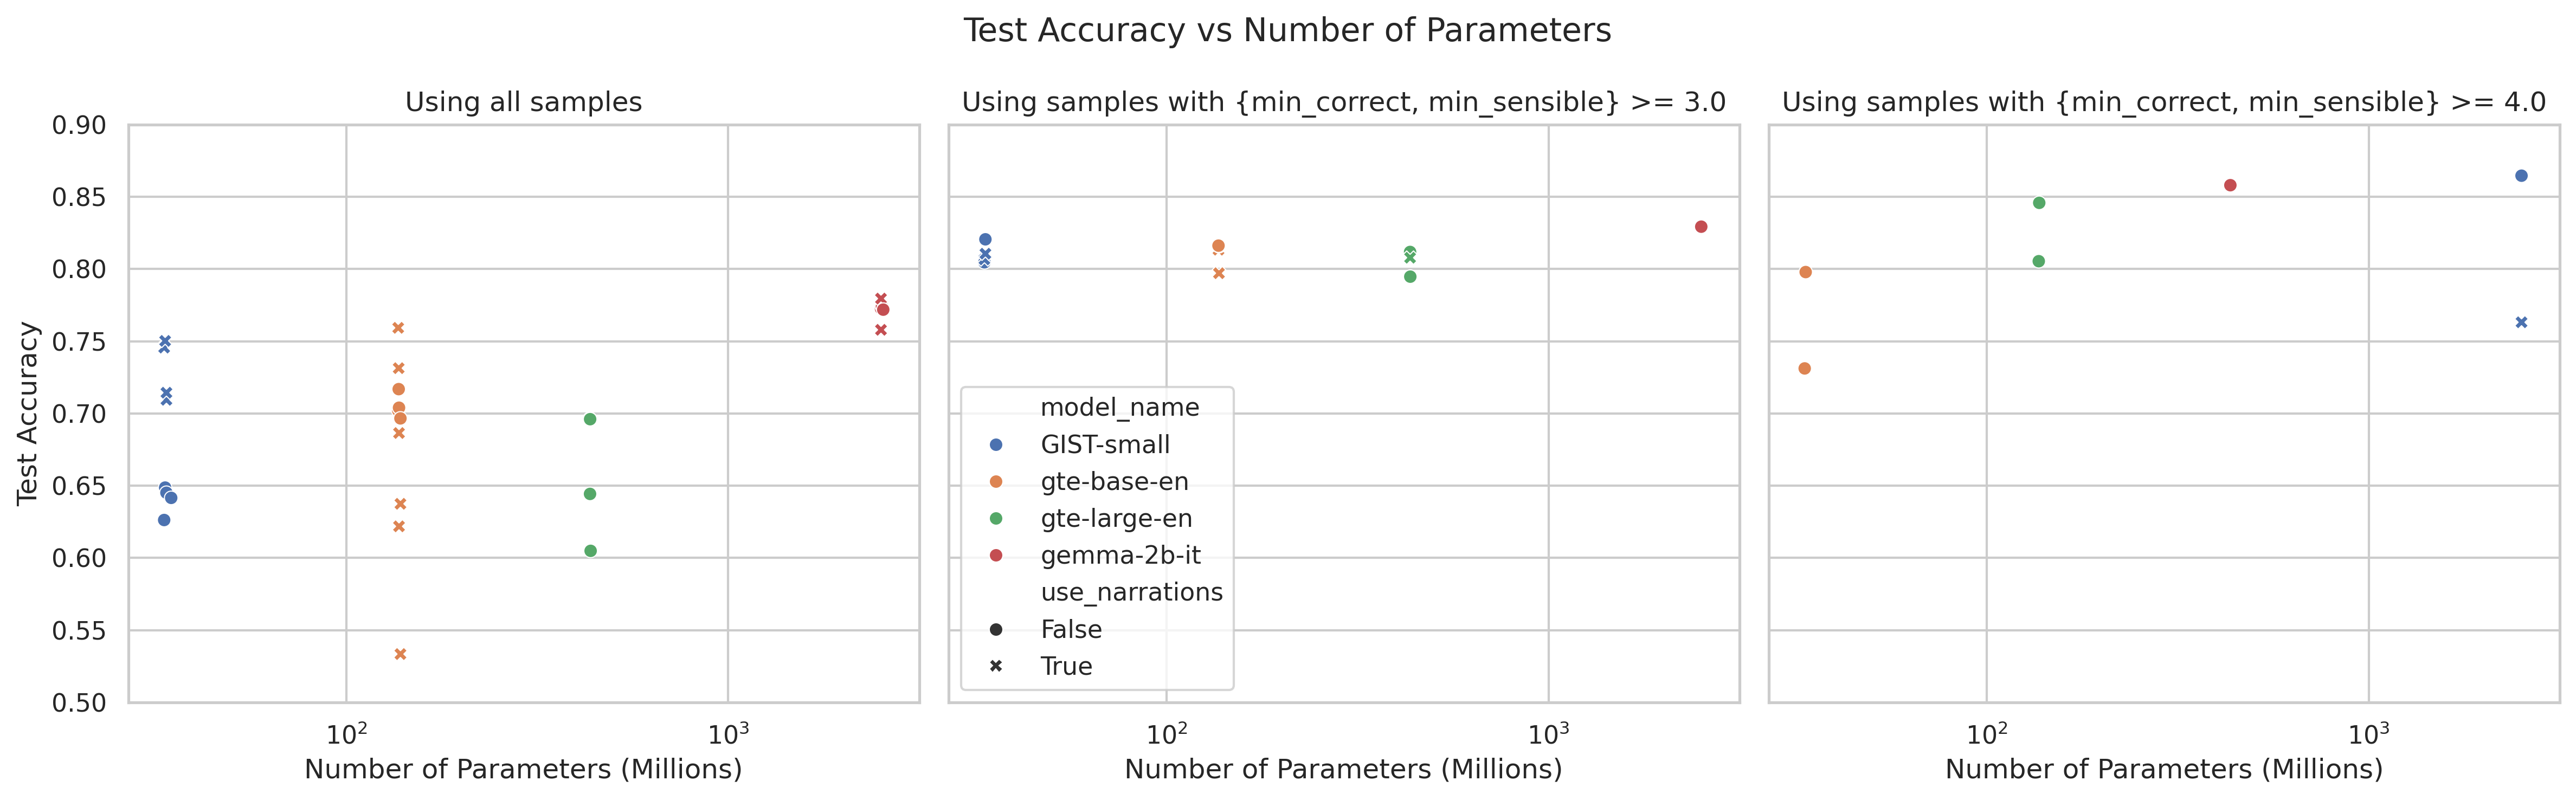

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 5), dpi=300, sharex=True, sharey=True)
fig.suptitle("Test Accuracy vs Number of Parameters")

for idx, min_correct in enumerate([0.0, 3.0, 4.0]):
    ax = axs[idx]
    df = runs_df.copy()
    df = df[df.test_accuracy > 0.5]
    df = df[df.min_correct == min_correct]
    print(df.shape)
    df['model_name'] = df['model_name'].str.split('/').str[1]
    df['model_name'] = df['model_name'].str.replace("-Embedding-v0", "").str.replace("-v1.5", "")
    sns.scatterplot(data=df, x='n_params (M)', y='test_accuracy', hue='model_name', style="use_narrations", ax=ax, legend=(idx==1))
    ax.set_xlabel('Number of Parameters (Millions)')
    ax.set_ylabel('Test Accuracy')
    ax.set_ylim(0.5, 0.9)
    ax.set_xscale('log')
    ax.set_title('Using all samples' if min_correct == 0.0 else f'Using samples with {{min_correct, min_sensible}} >= {min_correct}')
plt.tight_layout()
plt.show()

In [40]:
df.n_layers.unique()

array([nan])

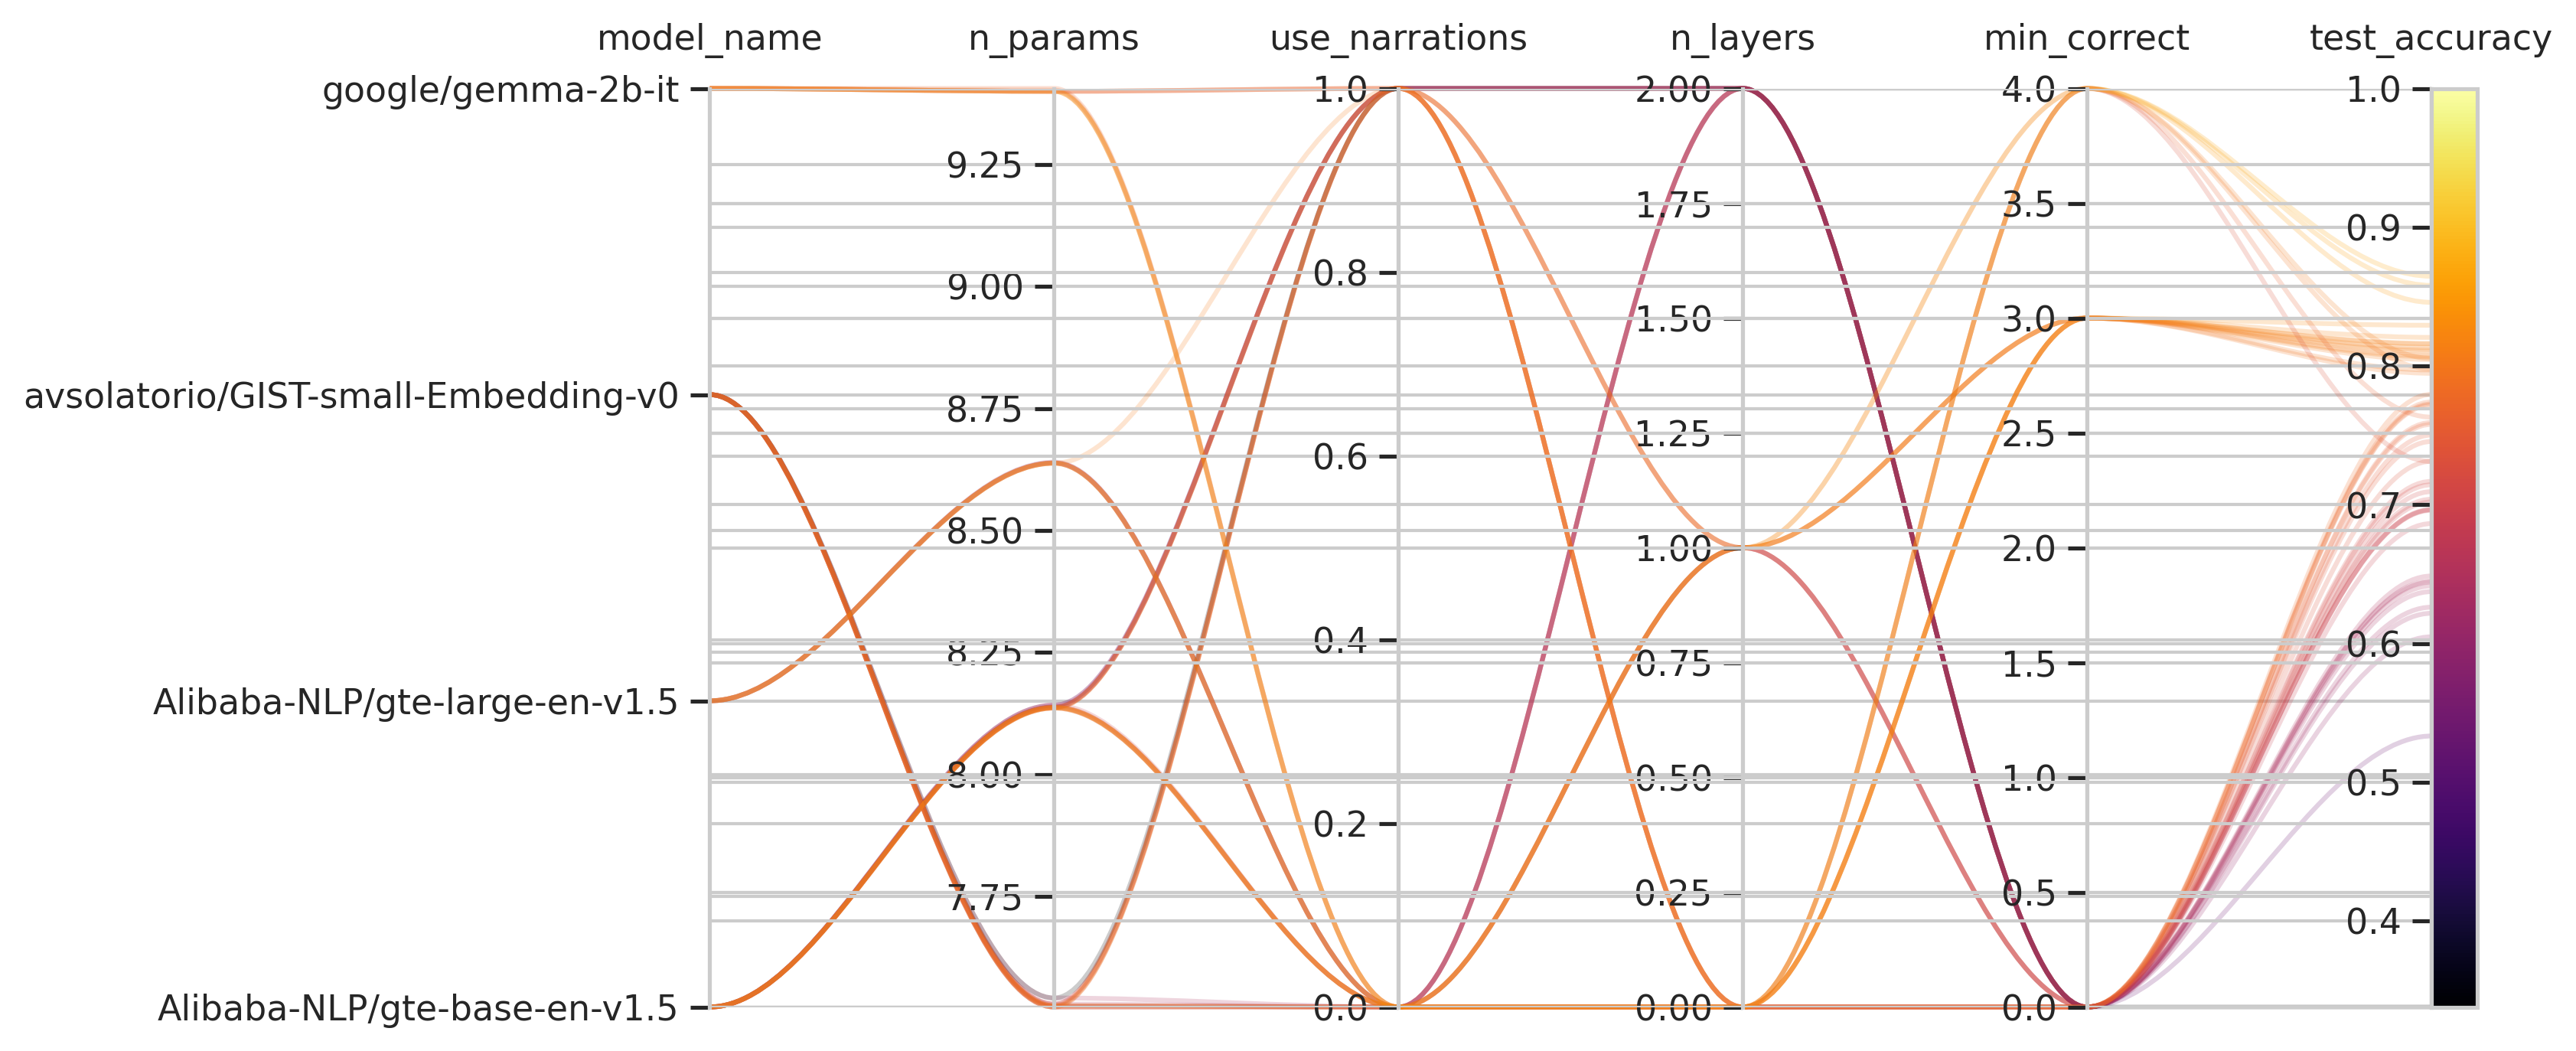

In [60]:
df = runs_df.copy()
df = df[df['model_name'] != 'google/mobilebert-uncased']
df = df[df.test_accuracy >= 0.0]
df = df[df.test_accuracy <= 1.0]
df['n_params'] = df['n_params'].apply(lambda x: 1 if x is None or x < 1 else np.log(x) / np.log(10))
df['n_layers'] = df['layer_sizes'].apply(lambda x: 0 if x is None else len(x))#(lambda x: 0 if x == "" or x is None else x.count(",")+1)
cols = 'model_name n_params use_narrations n_layers min_correct test_accuracy'.split(' ')
# cols = 'model_name test_accuracy'.split(' ')
# cols = 'use_narrations test_accuracy'.split(' ')
ytype = [[], [], 'categorical', [], [], []]
# ytype = ['categorical', []]
ylims = [[], [df.n_params.min(), df.n_params.max()], [], [0, df.n_layers.max()], [0.0, 4.0], [df.test_accuracy.min(), 1.0]]
# ylims = [[], [0.0, 1.0]]
pcp(df[cols].to_numpy(), cols, ytype, ylims, dpi=300, alpha=0.2)
plt.show()

In [ ]:
df = runs_df.copy()
df['model_name'] = df['model_name'].str.split('/').str[1]
df['model_name'] = df['model_name'].str.replace("-Embedding-v0", "").str.replace("-v1.5", "")
pd.plotting.parallel_coordinates(df, 'species', colormap=plt.get_cmap("Set2"))

In [54]:
runs_df.iloc[0].summary

{'train_accuracy': 0.7051947103090523,
 '_wandb': {'runtime': 15935},
 '_runtime': 15936.7199280262,
 'train_loss': 1.3530083281971583,
 'val_accuracy': 0.7163198247535597,
 'batch_loss': 1.3098729848861694,
 'stop_counter': 5,
 'best_val_loss': 1.3357096433639526,
 'test_accuracy': 0.6262322015334063,
 '_step': 1069,
 'val_loss': 1.3357096433639526,
 'test_loss': 1.4378318642747814,
 '_timestamp': 1722441269.7075691}

In [42]:
from transformers import AutoModel
for model_name in params_per_model.keys():
    model = AutoModel.from_pretrained(model_name, trust_remote_code=True)
    print(model_name, model.num_parameters(), model.num_parameters()/1e6)

avsolatorio/GIST-small-Embedding-v0 33360000 33.36
Alibaba-NLP/gte-base-en-v1.5 136776192 136.776192
Alibaba-NLP/gte-large-en-v1.5 434139136 434.139136
google/mobilebert-uncased 24581888 24.581888


In [111]:
model = AutoModel.from_pretrained('google/gemma-2b-it')
model

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.
Loading checkpoint shards: 100%|██████████| 2/2 [00:06<00:00,  3.16s/it]


GemmaModel(
  (embed_tokens): Embedding(256000, 2048, padding_idx=0)
  (layers): ModuleList(
    (0-17): 18 x GemmaDecoderLayer(
      (self_attn): GemmaSdpaAttention(
        (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
        (k_proj): Linear(in_features=2048, out_features=256, bias=False)
        (v_proj): Linear(in_features=2048, out_features=256, bias=False)
        (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        (rotary_emb): GemmaRotaryEmbedding()
      )
      (mlp): GemmaMLP(
        (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
        (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
        (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
        (act_fn): PytorchGELUTanh()
      )
      (input_layernorm): GemmaRMSNorm()
      (post_attention_layernorm): GemmaRMSNorm()
    )
  )
  (norm): GemmaRMSNorm()
)

In [112]:
model = AutoModel.from_pretrained('google/recurrentgemma-2b-it')
model

Loading checkpoint shards: 100%|██████████| 2/2 [00:07<00:00,  3.88s/it]


RecurrentGemmaModel(
  (embed_tokens): Embedding(256000, 2560, padding_idx=0)
  (layers): ModuleList(
    (0-1): 2 x RecurrentGemmaDecoderLayer(
      (temporal_pre_norm): RecurrentGemmaRMSNorm()
      (temporal_block): RecurrentGemmaRecurrentBlock(
        (linear_y): Linear(in_features=2560, out_features=2560, bias=True)
        (linear_x): Linear(in_features=2560, out_features=2560, bias=True)
        (linear_out): Linear(in_features=2560, out_features=2560, bias=True)
        (conv_1d): Conv1d(2560, 2560, kernel_size=(4,), stride=(1,), padding=(3,), groups=2560)
        (rg_lru): RecurrentGemmaRglru()
        (act_fn): PytorchGELUTanh()
      )
      (channel_pre_norm): RecurrentGemmaRMSNorm()
      (mlp_block): RecurrentGemmaMlp(
        (gate_proj): Linear(in_features=2560, out_features=7680, bias=True)
        (up_proj): Linear(in_features=2560, out_features=7680, bias=True)
        (down_proj): Linear(in_features=7680, out_features=2560, bias=True)
        (act_fn): PytorchGELU

In [33]:
model.num_parameters()

24581888

In [34]:
24581888/1e6

24.581888

In [43]:
from utils import load_data
x = load_data()

108 NaNs dropped. 18252 left


In [46]:
x.Action.unique().__len__()

6